<a href="https://colab.research.google.com/github/kozoB/vit-pathmnist-classifier/blob/main/ViT_Medical_Imaging_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Medical Imaging Using 'PathMNIST' Dataset

Fine-tuning a Vision Transformer (ViT/DeiT-Tiny) on medical imaging datasets (PathMNIST) for multi-class histopathology tissue classification.
The model is used 'huggingface' and the 'PathMNIST' multi-class histopathology tissue dataset is taken from kaggle.
The Vision Transformer's ability to be levaraged and domain-specific fine-tuned into the medical imaging area.

# Import Libraries

In [ ]:
import importlib.util
import subprocess
import sys

# Install medmnist only if not already installed
if importlib.util.find_spec("medmnist") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])

import medmnist
from medmnist import PathMNIST
from medmnist import INFO

from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

Mounted at /content/drive


# Load And Preprocess Dataset

In [ ]:
data_flag = 'pathmnist'
download = True

# Load metadata
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# Resize to 224x224 for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [ ]:
from torch.utils.data import Dataset

class TransformedMedMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
train_dataset_raw = DataClass(split='train', download=download)
test_dataset_raw = DataClass(split='test', download=download)

train_dataset = TransformedMedMNIST(train_dataset_raw, transform=transform)
test_dataset = TransformedMedMNIST(test_dataset_raw, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 206M/206M [02:32<00:00, 1.35MB/s]


# EDA

## Plot Random Images From Dataset

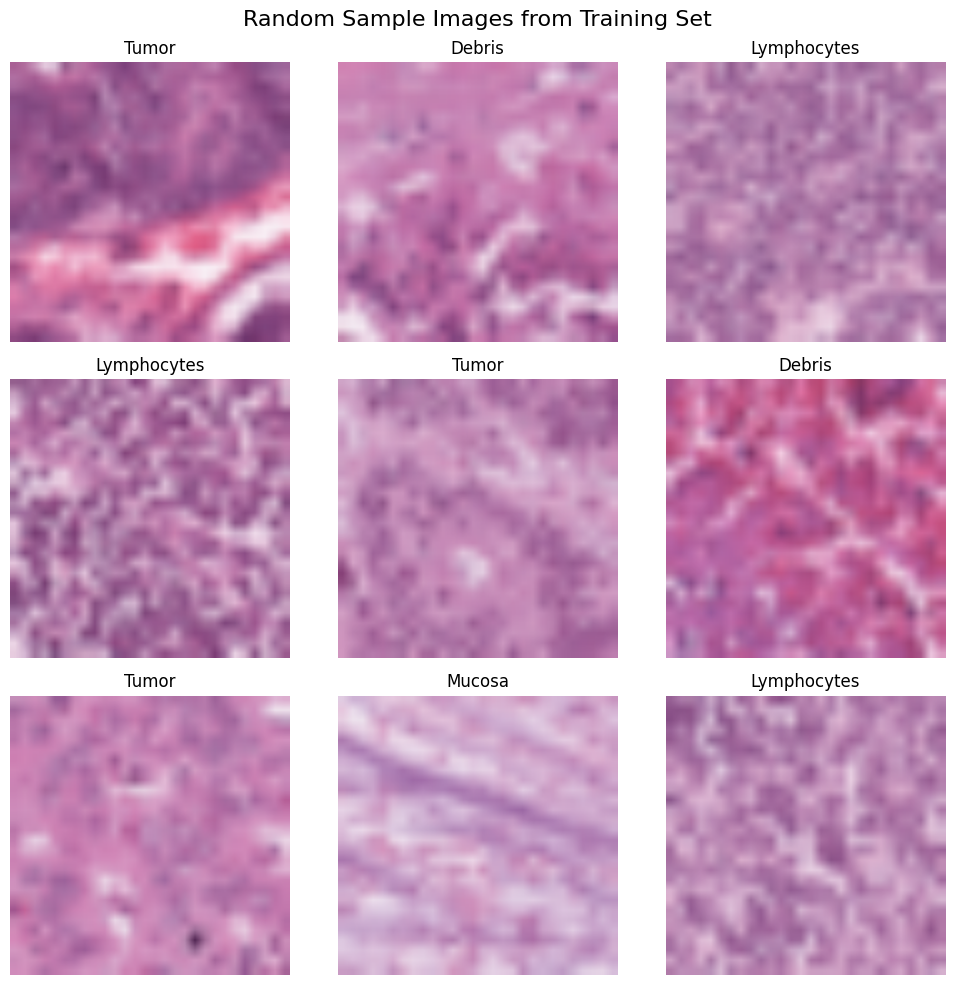

In [ ]:
class_names = [
    "Adipose", "Background", "Debris", "Lymphocytes", "Mucosa",
    "Smooth muscle", "Normal mucosa", "Stroma", "Tumor"
]

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# Show 9 random images from train_dataset
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
indices = random.sample(range(len(train_dataset)), 9)

for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = img * 0.5 + 0.5  # unnormalize
    img_np = img.numpy().transpose(1, 2, 0)
    label_idx = int(label.item())  # convert tensor to int
    ax = axes[i // 3, i % 3]
    ax.imshow(img_np)
    ax.set_title(class_names[label_idx])
    ax.axis("off")

plt.suptitle("Random Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()

## Plot Class Distribution

<ipython-input-15-5befcac117e0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='viridis')


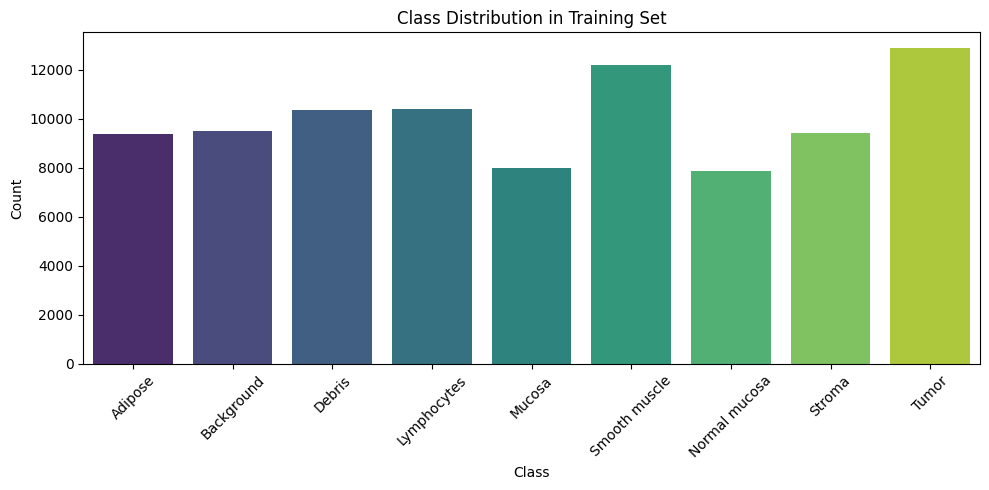

In [ ]:
labels = [int(label.item()) for _, label in train_dataset_raw]

plt.figure(figsize=(10, 5))
sns.countplot(x=labels, palette='viridis')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The data is more or less even, with two classes which are much more frequent and 2 that are less.
The model is expected to handle the data distribution fairly.

# Load Petrained Model

In [ ]:
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    "facebook/deit-tiny-patch16-224",
    num_labels=9,
    ignore_mismatched_sizes=True
).to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
!nvidia-smi

CUDA available: True
Current device: 0
Fri May 23 16:19:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |     124MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------

In [ ]:
from torch import nn
from torch.optim import AdamW

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-5)

Loss function - Cross-Entropy Loss is the standard loss function for multi-class classification problems, it measures how well the predicted class probabilities match the true labels.

Optimizer - AdamW is a variation of the Adam optimizer that correctly decouples weight decay (L2 regularization) from the optimization step.
Teh AdamW optimizer is recommended by Hugging Face Transformers and most modern transformer papers. It also helps prevent overfitting and improves generalization.
It Works well on large models with many parameters (like ViTs).

Learning Rate - A small learning rate is used as the model is only being fine tuned to the 'PathMNIST' dataset and not trained from scratch. We want the model to train subtly and in a stable updates, to avoid “forgetting” the useful pretrained features.

# Model Training

In [ ]:
from tqdm import tqdm

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            total_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

## Training Loop And Save Best Model

In [ ]:
EPOCHS = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
patience = 2
wait = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        model.save_pretrained(save_path)  # Save best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Loss = 0.1953, Train Acc = 0.9393, Val Loss = 0.3175, Val Acc = 0.8983
Epoch 2: Train Loss = 0.0678, Train Acc = 0.9787, Val Loss = 0.2399, Val Acc = 0.9304
Epoch 3: Train Loss = 0.0428, Train Acc = 0.9860, Val Loss = 0.2814, Val Acc = 0.9242
Epoch 4: Train Loss = 0.0322, Train Acc = 0.9900, Val Loss = 0.3100, Val Acc = 0.9237
Early stopping triggered.


As the model converges fast during training, a number of 5 epochs maximum was chosen.
Also, early stopping was intoduced with patience of 2, to prevent the model from overfitting and from the accuracy to degrade.
The best model is saved.

# Accuracy And Loss Plots

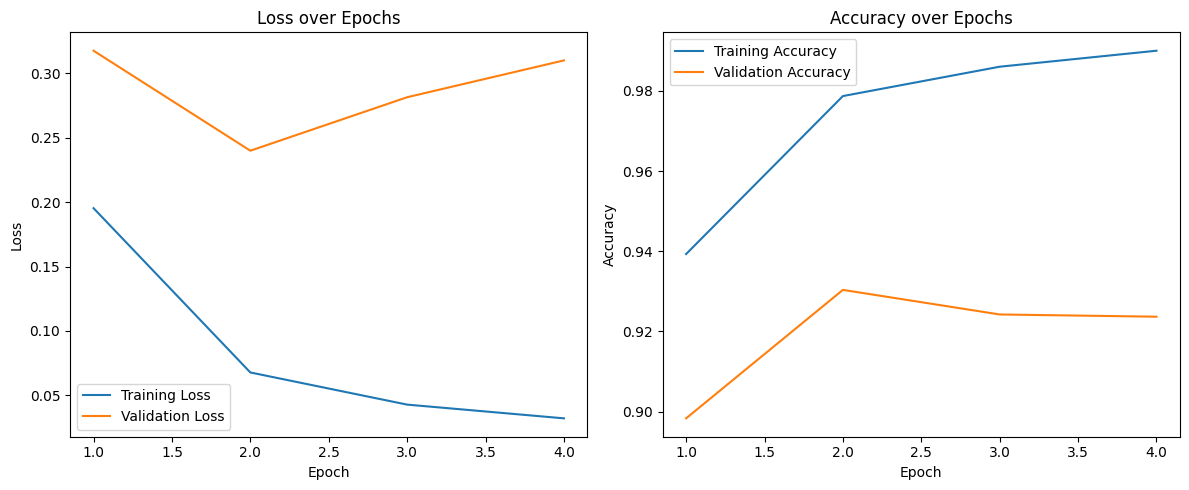

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

As the loss and accuracy of the validation stops improving pretty fast, the early stopping is triggered after a few epochs.

# Load Model From Drive

In [ ]:
from google.colab import drive
from transformers import ViTForImageClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/Masters Degree/Deep Learning Course'

model = ViTForImageClassification.from_pretrained(load_path)
model.to(device)  # Move to GPU if available

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# Evaluations

In [ ]:
import importlib.util
import subprocess
import sys

# Install medmnist only if not already installed
if importlib.util.find_spec("medmnist") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])

import medmnist
from medmnist import PathMNIST
from medmnist import INFO

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# Resize to 224x224 for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

class TransformedMedMNIST(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

data_flag = 'pathmnist'
download = True

# Load metadata
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

test_dataset_raw = DataClass(split='test', download=download)
test_dataset = TransformedMedMNIST(test_dataset_raw, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
class_names = [
    "Adipose", "Background", "Debris", "Lymphocytes", "Mucosa",
    "Smooth muscle", "Normal mucosa", "Stroma", "Tumor"
]

## Confusion Matrix

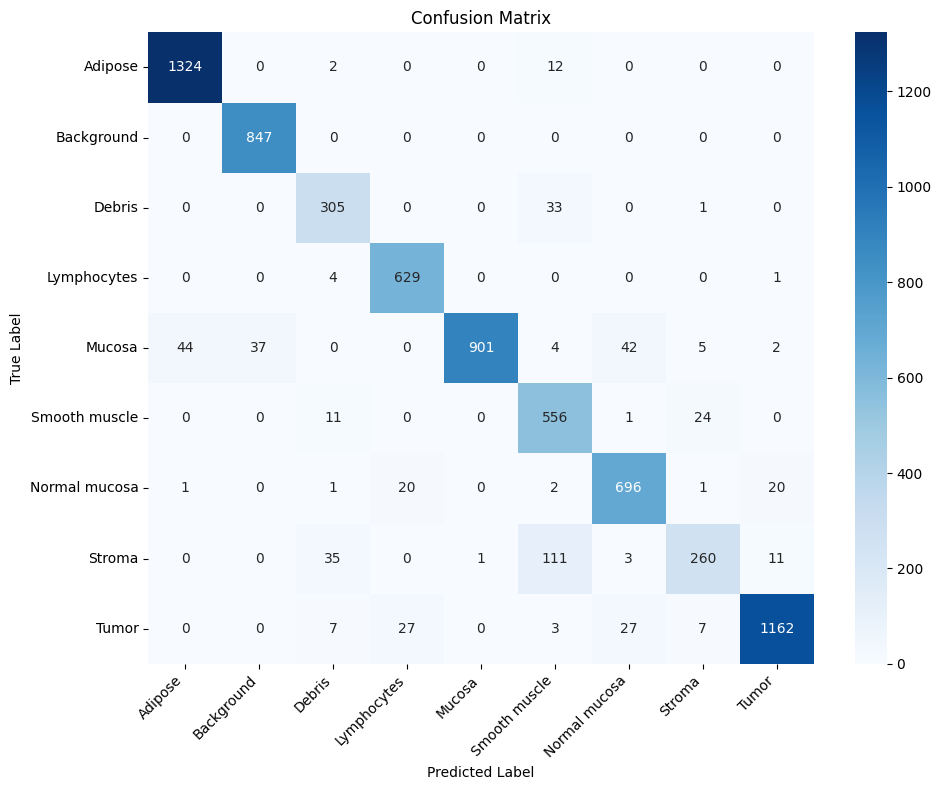

               precision    recall  f1-score   support

      Adipose     0.9671    0.9895    0.9782      1338
   Background     0.9581    1.0000    0.9786       847
       Debris     0.8356    0.8997    0.8665       339
  Lymphocytes     0.9305    0.9921    0.9603       634
       Mucosa     0.9989    0.8705    0.9303      1035
Smooth muscle     0.7712    0.9392    0.8469       592
Normal mucosa     0.9051    0.9393    0.9219       741
       Stroma     0.8725    0.6176    0.7232       421
        Tumor     0.9716    0.9424    0.9568      1233

     accuracy                         0.9304      7180
    macro avg     0.9123    0.9100    0.9070      7180
 weighted avg     0.9339    0.9304    0.9292      7180



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Prediction collection function
def get_predictions(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.squeeze().cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, true_labels = get_predictions(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report with Class Names
print(classification_report(true_labels, preds, target_names=class_names, digits=4))

The model produces a very high f1-score for the classes.
It had a difficulty with 'storma' class, which had a few missclasified images and a relatively lower f1-score than the other classs.
As this class is fairly sampled in the data, a more advanced approach like combining CNN with ViT into a hybrid model could be effective.
This could help uncover additional features and patterns that the ViT alone may have difficulty detecting.

## ROC, AUC Scores

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
y_true_bin = label_binarize(true_labels, classes=list(range(9)))  # For 9 classes

# Get probabilities instead of hard predictions
model.eval()
probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images).logits
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        probs.extend(prob)

# Compute ROC-AUC per class (macro-avg)
roc_auc = roc_auc_score(y_true_bin, np.array(probs), average="macro", multi_class="ovr")
print(f"Macro ROC-AUC: {roc_auc:.4f}")

Macro ROC-AUC: 0.9944


Very high ROC-AUC value (almost 1) which means the model makes a good job distinguishing between the classes.
Even for underrepresented classes, performance remains high, since macro-averaging doesn’t favor majority classes.

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

## Show Random Predictions From Test Set

In [ ]:
def show_predictions(model, dataloader, num_samples=8):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(16, 8))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                plt.subplot(2, num_samples // 2, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # unnormalize

                plt.imshow(img)
                pred_label = preds[i].item()
                true_label = labels[i].item()
                confidence = probs[i][pred_label].item()

                title_color = "green" if pred_label == true_label else "red"
                plt.title(
                    f"Pred: {class_names[pred_label]}\n"
                    f"True: {class_names[true_label]}\n"
                    f"Conf: {confidence*100:.1f}%",
                    color=title_color,
                    fontsize=10
                )
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

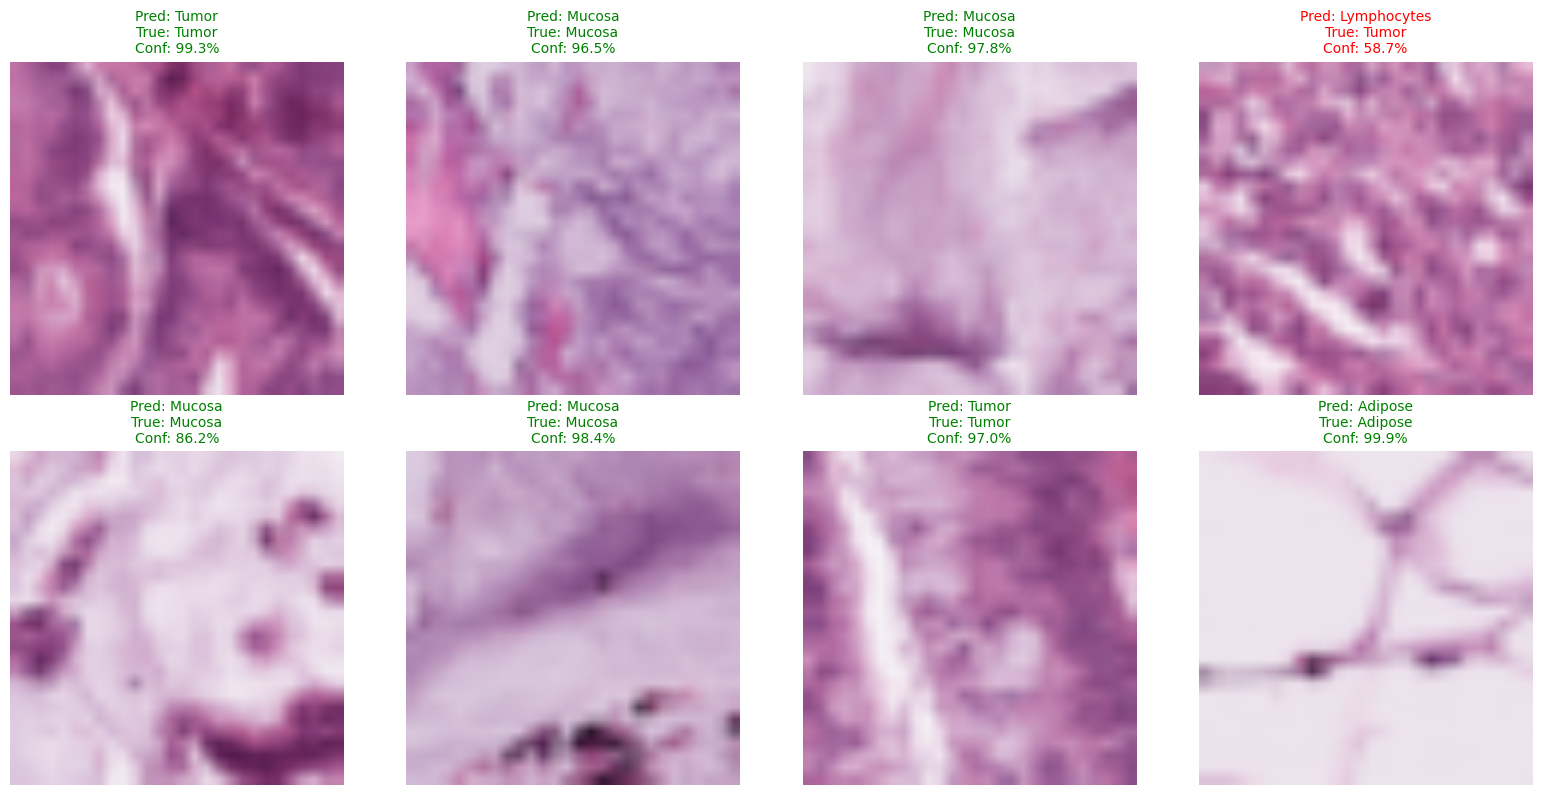

In [ ]:
show_predictions(model, test_loader, num_samples=8)

# Conclusion

As we can see, the ViT model performs very well on the 'pathmnist' medical images dataset, with high accuracy and f1 score in almost all of the classes.

It has a difficulty with classifying the 'stroma' class, as seen by the confusion matrix, and it's f1 score, which stands out more than any other class, but the model still manages to classify most of the 'stroma' images correctly.

Integrating CNN into a hybrid model of both ViT and CNN might help increase the accuracy and better the model's performance, allowing it to generalize better.

This hybrid architecture would combine the local feature extraction capabilities of CNNs with the global context modeling of ViTs, enabling the model to capture both fine-grained details and long-range dependencies.